<a href="https://colab.research.google.com/github/kobrue02/evaluating-llm-generated-nlu-data/blob/main/bin/notebooks/train_eval_nlu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/kobrue02/evaluating-llm-generated-nlu-data/
%cd evaluating-llm-generated-nlu-data

Cloning into 'evaluating-llm-generated-nlu-data'...
remote: Enumerating objects: 1012, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 1012 (delta 75), reused 86 (delta 41), pack-reused 884 (from 1)
Receiving objects: 100% (1012/1012), 6.72 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (673/673), done.
/content/evaluating-llm-generated-nlu-data


In [2]:
from bin.framework.nlu_model import IntentClassifier
from bin.utils.methods import *
from sklearn.neural_network import MLPClassifier

In [3]:
model = IntentClassifier(model=MLPClassifier())
datasets = [
    "zero_shot_simple_data",
    "one_shot_simple_data",
    "few_shot_simple_data",
    "chain_of_thought_simple_data",
    "persona_based_prompt_s1_data",
    "attribute_controlled_prompt_data"
]

In [4]:
from bin.utils.methods import load_sipgate_dataset

golden_df = load_sipgate_dataset()
golden_df = golden_df.groupby('intent').sample(n=5, random_state=42)
golden_df.head()

,text,intent,occurrences,phraseEntTypes,annotations
8,wie aktiviere ich den anrufbeantworter,account_activate_item,3,appWebItem,3f77257d-28ca-47ed-a7bf-b3ea3ed82827
16,wie kann ich eine esim aktivieren,account_activate_item,2,simType,34c8a394-d8c2-4a0a-a662-28ccf8f6dda2
0,esim aktivieren,account_activate_item,26,simType,c8386639-9813-41b0-b1f6-73f038fe57fc
23,sim karte aktivierung,account_activate_item,2,simType,ed14dc49-f0ba-4757-afdc-2607c92c031c
11,sim karte freischalten,account_activate_item,3,simType,29e21205-cecb-4166-aa22-7abcd0ac4300


In [5]:
reports = {}
for fname in datasets:
    df = load_df(fname)
    model.fit(df)
    report = model.evaluate(golden_df)
    reports[fname] = report
    model.reset()

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and bei

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
def stacked_bar_chart(reports):
    # Create a dictionary to store the weighted averages
    weighted_averages = {}

    for dataset_name, report in reports.items():
        weighted_averages[dataset_name] = {}
        for intent, metrics in report.items():
            if intent not in {'accuracy', 'macro avg', 'weighted avg'}:
                weighted_averages[dataset_name][intent] = {
                    'precision': metrics['precision'],
                    'recall': metrics['recall'],
                    'f1-score': metrics['f1-score']
                }

    # Convert the weighted_averages dictionary to a Pandas DataFrame
    df_list = []
    for dataset_name, intents in weighted_averages.items():
        for intent, metrics in intents.items():
            df_list.append({
                'dataset': dataset_name,
                'intent': intent,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1-score': metrics['f1-score']
            })
    df = pd.DataFrame(df_list)

    # Generate individual plots
    for dataset_name in weighted_averages.keys():
        dataset_df = df[df['dataset'] == dataset_name]
        dataset_df = dataset_df.set_index('intent')[['precision', 'recall', 'f1-score']]

        # Create a new figure for each dataset
        plt.figure(figsize=(12, 6))
        dataset_df.plot(kind='bar', stacked=True, colormap="Set3")

        plt.title(f'Metrics per intent for {dataset_name}')
        plt.ylabel('Score')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

        # Add a horizontal line with the weighted average F1 score
        weighted_avg_f1 = df[df['dataset'] == dataset_name]['f1-score'].mean()
        plt.axhline(y=weighted_avg_f1, color='b', linestyle='-')
        plt.xticks([])

        # Save the figure
        plt.savefig(f'output/{dataset_name}.png', bbox_inches='tight')
        plt.close()  # Close the figure to free memory

    print("Plots saved successfully!")

In [8]:
stacked_bar_chart(reports)

Plots saved successfully!


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [9]:
def heatmap(reports):
  for dataset_name, report in reports.items():
    # Convert report to DataFrame
    df_report = pd.DataFrame(report).transpose()
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    # do not show text on the cells
    sns.heatmap(df_report.iloc[:-1, :3], annot=False, cmap="YlGnBu", fmt='.2f')
    plt.title(f'{dataset_name.title()} Classification Report Heatmap')
    plt.show()

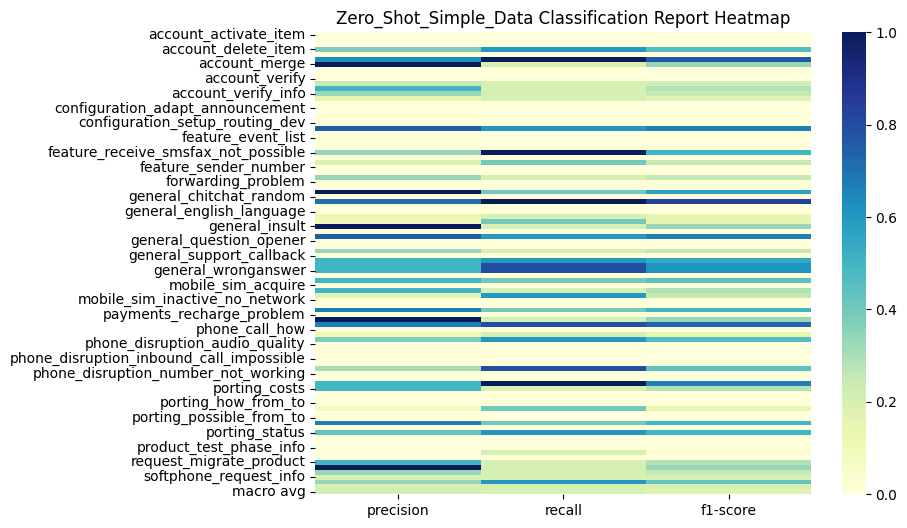

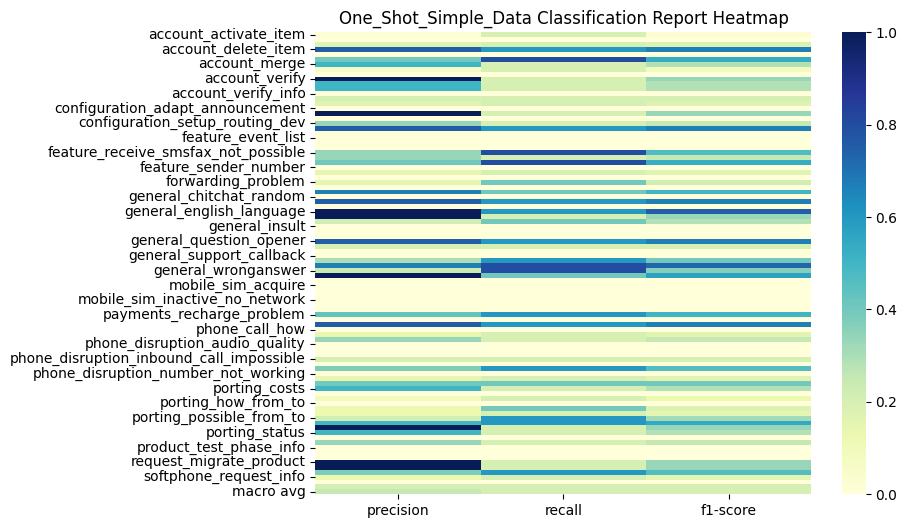

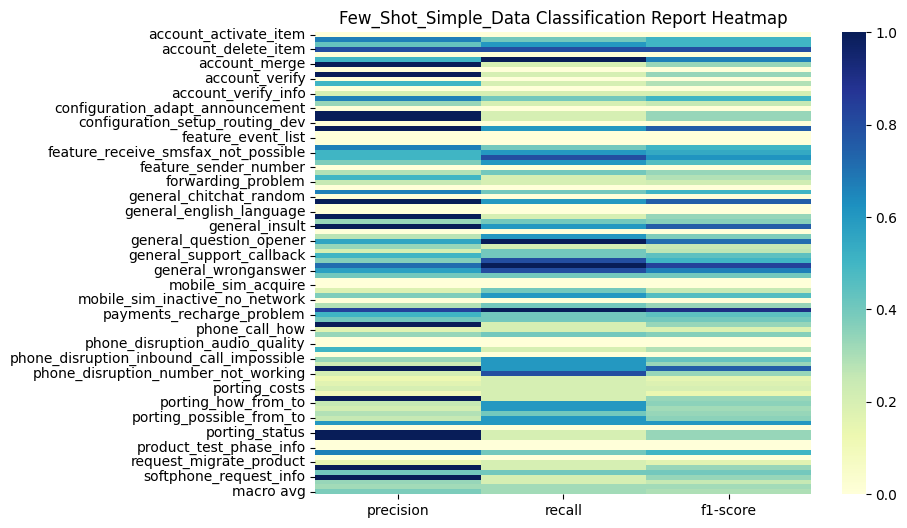

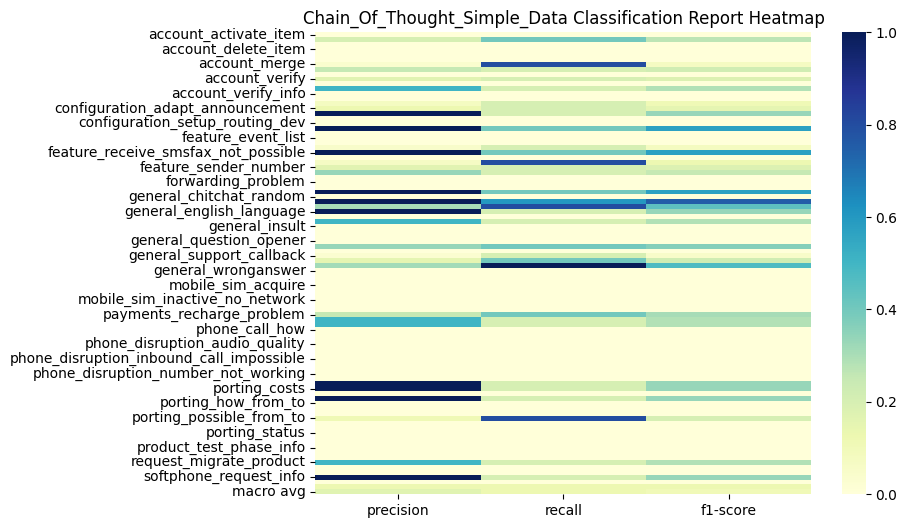

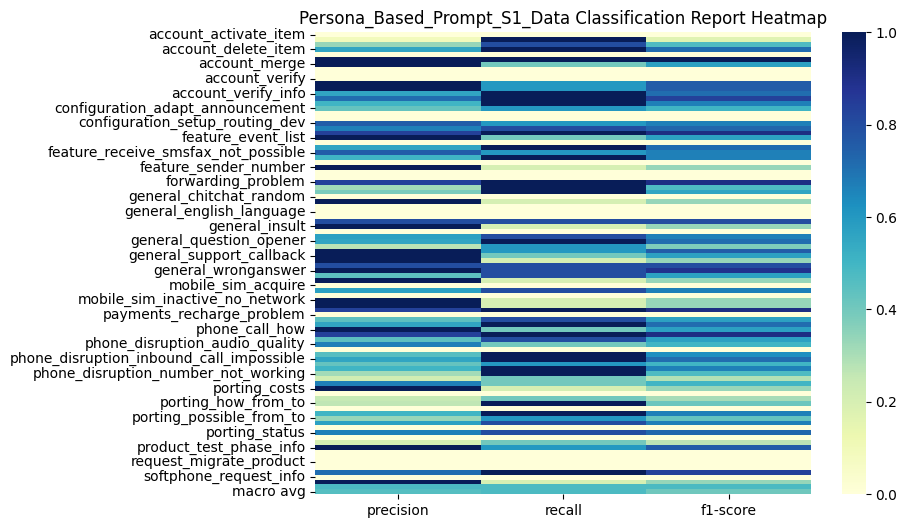

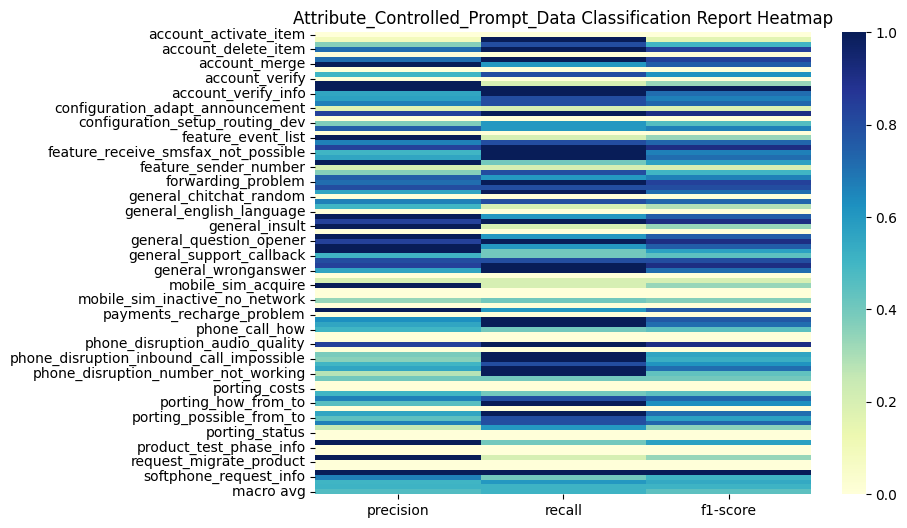

In [10]:
heatmap(reports)

In [12]:
def create_weighted_average_table(reports):
    weighted_averages = {}
    for dataset_name, report in reports.items():
        weighted_averages[dataset_name] = report['weighted avg']['f1-score']

    df = pd.DataFrame(weighted_averages, index=['Weighted Average F1-score']).transpose()
    return df
df = create_weighted_average_table(reports)
df_transposed = df.transpose()
df_transposed
df_transposed.to_csv('output/phi_weighted_average_f1_scores.csv')

In [ ]:
model = IntentClassifier(model=MLPClassifier())
train_df, test_df = model.split_dataset(df)
model.fit(train_df)
report = model.classification_report(test_df)
print(report)

In [ ]:
report_dict = model.evaluate(test_df)
stacked_bar_chart({
    "sipgate": report_dict
})
plt.show()

Plots saved successfully!


<Figure size 1200x600 with 0 Axes>